In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../../..")

# Third party imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
# from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
from librep.transforms import UMAP
from tabulate import tabulate

2022-10-21 19:42:33.147932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 19:42:33.147962: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from Experiments_topoae_KuHar20Hz_helper import *
kuhar_data = obtainKuHar20Hz()
train_HD = kuhar_data['train_HD']
train_LD = kuhar_data['train_LD']
train_Y = kuhar_data['train_Y']
test_HD = kuhar_data['test_HD']
test_LD = kuhar_data['test_LD']
test_Y = kuhar_data['test_Y']

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [5]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1)': ['-']*9,
    'Topo-AEv2 (L=100)': ['-']*9,
    'M-AE (L=1)': ['-']*9,
    'M-AE (L=100)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │ -            │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │ -            │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │ -            │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────

# Visualization helper

In [6]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [9]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [10]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [11]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Reducing with Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [12]:
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 0
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam = topoae_lambda,
    ae_kwargs = kwargs,
    input_shape = input_shape,
    patience=10
)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:297.3386, Loss-ae:297.3386, Loss-topo:192.6305
Epoch:2, P:10, Loss:298.1573, Loss-ae:298.1573, Loss-topo:243.5778
Epoch:3, P:9, Loss:292.0746, Loss-ae:292.0746, Loss-topo:392.4125
Epoch:4, P:10, Loss:265.4814, Loss-ae:265.4814, Loss-topo:400.3606
Epoch:5, P:10, Loss:245.6964, Loss-ae:245.6964, Loss-topo:226.4440
Epoch:6, P:10, Loss:211.3123, Loss-ae:211.3123, Loss-topo:128.1175
Epoch:7, P:10, Loss:249.2979, Loss-ae:249.2979, Loss-topo:562.7612
Epoch:8, P:9, Loss:248.6436, Loss-ae:248.6436, Loss-topo:398.6452
Epoch:9, P:8, Loss:201.7351, Loss-ae:201.7351, Loss-topo:320.5509
Epoch:10, P:10, Loss:207.8156, Loss-ae:207.8156, Loss-topo:2215.1896
Epoch:11, P:9, Loss:163.5840, Loss-ae:163.5840, Loss-topo:1788.5204
Epoch:12, P:10, Loss:160.1949, Loss-ae:160.1949, Loss-topo:4804.3489
Epoch:13, P:10, Loss:180.8296, Loss-ae:180.8296, Loss-topo:3999.3067
Epoch:14, P:9, Loss:161.7088, Loss-ae:161.7088, Loss-topo:2646.9556
Epoch:15, P:8, Loss:162.8247, Loss-ae:162.8247, Loss-topo

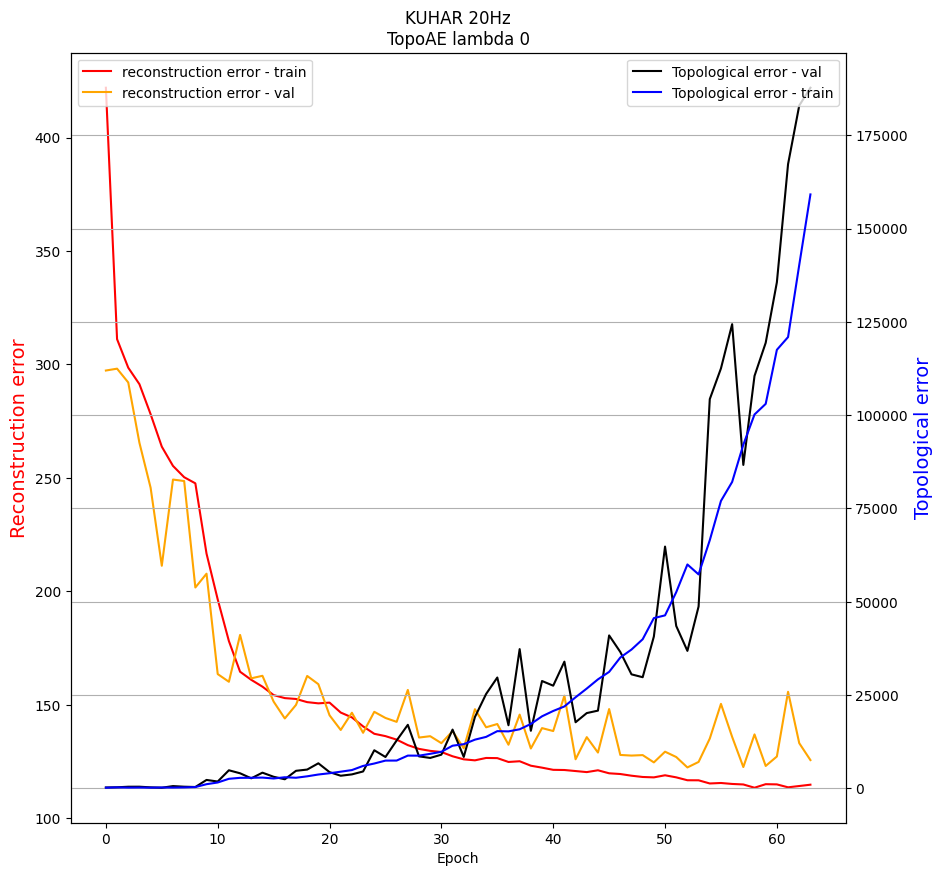

In [13]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [14]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [15]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.4280423280423281,
 'RF-F1': 0.4378071859787001,
 'SVC-ACC': 0.3386243386243386,
 'SVC-F1': 0.38716365089736665,
 'KNN-ACC': 0.4074074074074074,
 'KNN-F1': 0.4111452196901072}

In [16]:
table_info['Generic-AE'][0] = experiments_result['RF-ACC']
table_info['Generic-AE'][1] = experiments_result['RF-F1']
table_info['Generic-AE'][2] = experiments_result['SVC-ACC']
table_info['Generic-AE'][3] = experiments_result['SVC-F1']
table_info['Generic-AE'][4] = experiments_result['KNN-ACC']
table_info['Generic-AE'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │ 0.4280423280423281  │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │ 0.4378071859787001  │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │ 0.3386243386243386  │ -                 │ -                   │ -            │ -              │


## Obtain quality metrics

In [17]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [18]:
metrics_report

{'residual variance (pearson)': 0.09838765129466553,
 'residual variance (spearman)': 0.15486733809261322,
 'trustworthiness': 0.8757352292849953,
 'continuity': 0.9459177094278346,
 'co k nearest neighbor size': 0.3821286472148541,
 'local continuity meta criterion': 0.3395754557254924,
 'local property': 0.5099898886458237,
 'global property': 0.889244783126964}

In [19]:
table_info['Generic-AE'][6] = metrics_report['trustworthiness']
table_info['Generic-AE'][7] = metrics_report['continuity']
table_info['Generic-AE'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │     0.428042 │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │     0.437807 │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │     0.338624 │ -                 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────

## Visualization

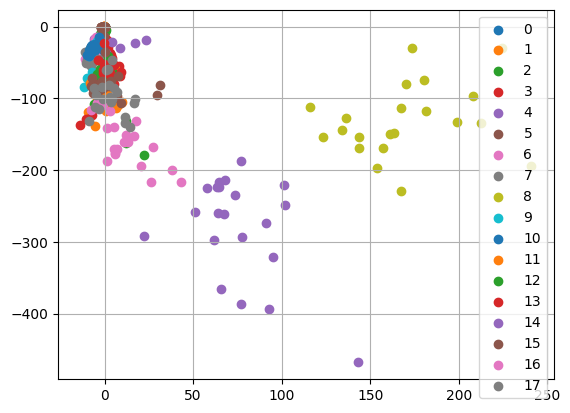

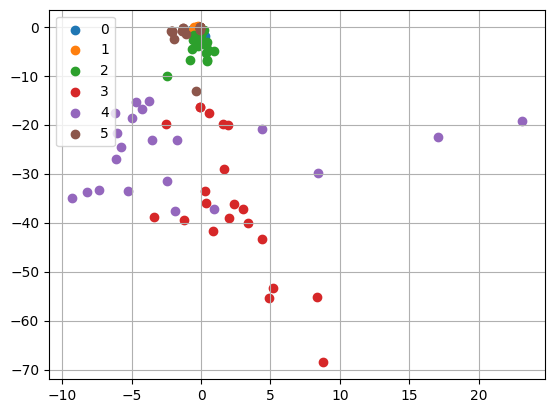

In [20]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=1)

In [21]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 1
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:404.4081, Loss-ae:392.1951, Loss-topo:12.2130
Epoch:2, P:10, Loss:364.4564, Loss-ae:348.7960, Loss-topo:15.6603
Epoch:3, P:10, Loss:298.5548, Loss-ae:291.1652, Loss-topo:7.3897
Epoch:4, P:10, Loss:288.2145, Loss-ae:274.0215, Loss-topo:14.1930
Epoch:5, P:10, Loss:257.7631, Loss-ae:255.3855, Loss-topo:2.3775
Epoch:6, P:10, Loss:251.9463, Loss-ae:250.7889, Loss-topo:1.1573
Epoch:7, P:10, Loss:236.5982, Loss-ae:235.1600, Loss-topo:1.4382
Epoch:8, P:10, Loss:238.5369, Loss-ae:233.9697, Loss-topo:4.5672
Epoch:9, P:9, Loss:209.2779, Loss-ae:203.0827, Loss-topo:6.1953
Epoch:10, P:10, Loss:185.3924, Loss-ae:181.4917, Loss-topo:3.9006
Epoch:11, P:10, Loss:197.3306, Loss-ae:192.4669, Loss-topo:4.8637
Epoch:12, P:9, Loss:188.8663, Loss-ae:184.8638, Loss-topo:4.0026
Epoch:13, P:8, Loss:177.3245, Loss-ae:173.0548, Loss-topo:4.2697
Epoch:14, P:10, Loss:186.6178, Loss-ae:179.4270, Loss-topo:7.1908
Epoch:15, P:9, Loss:155.6578, Loss-ae:150.9298, Loss-topo:4.7280
Epoch:16, P:10, Loss

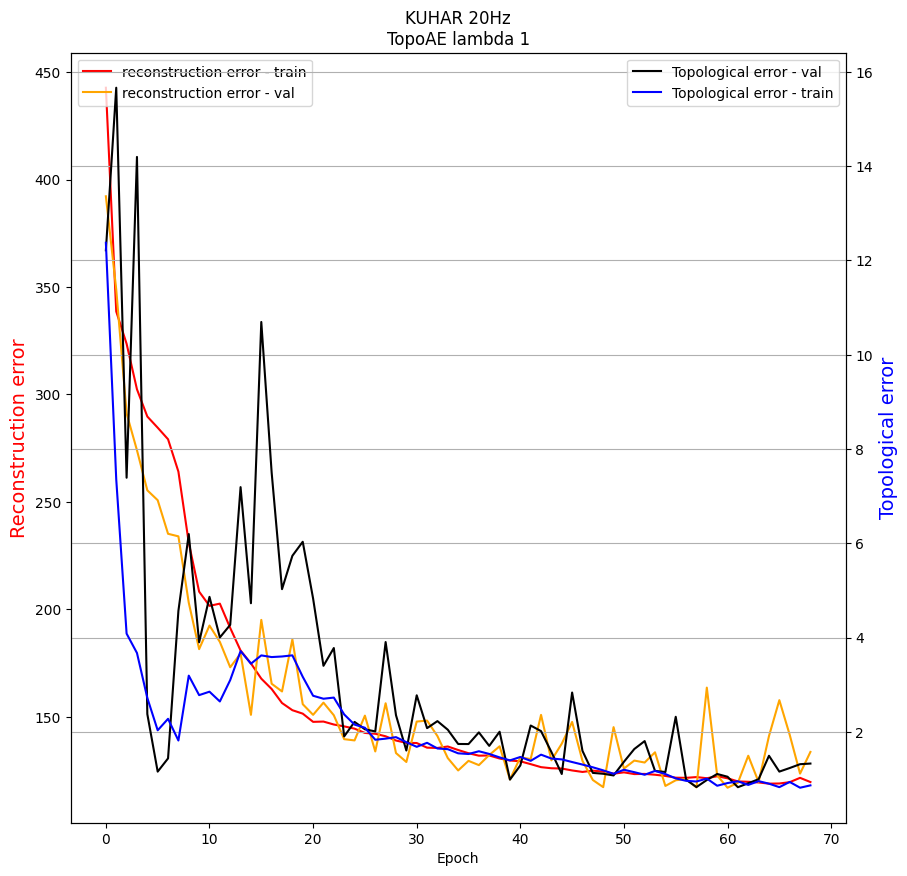

In [22]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [23]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [24]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.4931216931216931,
 'RF-F1': 0.5044510456332219,
 'SVC-ACC': 0.41005291005291006,
 'SVC-F1': 0.45433696578023297,
 'KNN-ACC': 0.46825396825396826,
 'KNN-F1': 0.47514845105183223}

In [25]:
table_info['Topo-AEv2 (L=1)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=1)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=1)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=1)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=1)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=1)'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │     0.428042 │ 0.4931216931216931  │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │     0.437807 │ 0.5044510456332219  │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │     0.338624 │ 0.41005291005291006 │ -                   │ -            │ -              │
├─────────────────┼────────┼────────────

## Obtain quality metrics

In [26]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [27]:
metrics_report

{'residual variance (pearson)': 0.13754223872181381,
 'residual variance (spearman)': 0.17724670272117116,
 'trustworthiness': 0.881003530570108,
 'continuity': 0.9542931695775807,
 'co k nearest neighbor size': 0.40484084880636606,
 'local continuity meta criterion': 0.36228765731700435,
 'local property': 0.5010520776559737,
 'global property': 0.8794640650356929}

In [28]:
table_info['Topo-AEv2 (L=1)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=1)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=1)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │     0.428042 │          0.493122 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │     0.437807 │          0.504451 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │     0.338624 │          0.410053 │ -                   │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────

## Visualization

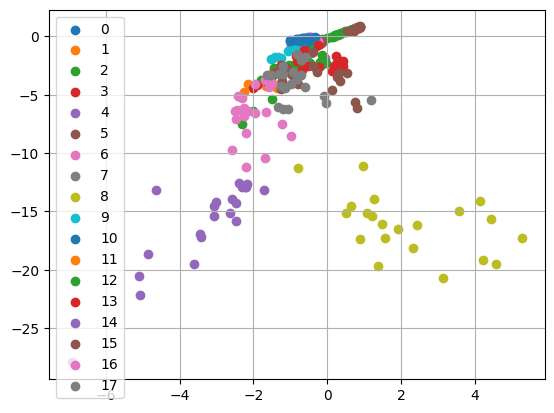

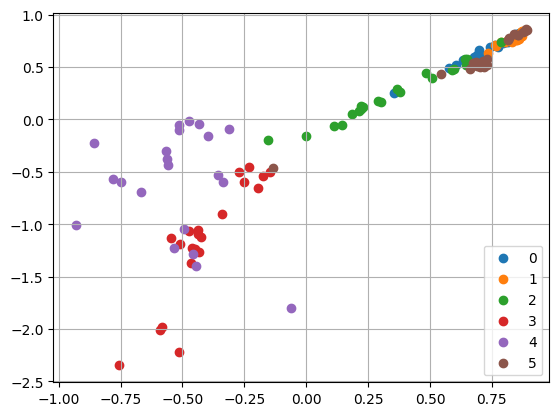

In [29]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=100)

In [30]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:442.9514, Loss-ae:406.5025, Loss-topo:0.3645
Epoch:2, P:10, Loss:372.2470, Loss-ae:319.2032, Loss-topo:0.5304
Epoch:3, P:10, Loss:352.4388, Loss-ae:330.3333, Loss-topo:0.2211
Epoch:4, P:10, Loss:245.3014, Loss-ae:239.7261, Loss-topo:0.0558
Epoch:5, P:10, Loss:251.9019, Loss-ae:241.5484, Loss-topo:0.1035
Epoch:6, P:9, Loss:260.2372, Loss-ae:252.0711, Loss-topo:0.0817
Epoch:7, P:8, Loss:244.4542, Loss-ae:240.4515, Loss-topo:0.0400
Epoch:8, P:10, Loss:235.9640, Loss-ae:232.1186, Loss-topo:0.0385
Epoch:9, P:10, Loss:242.4790, Loss-ae:240.1551, Loss-topo:0.0232
Epoch:10, P:9, Loss:232.4923, Loss-ae:220.8136, Loss-topo:0.1168
Epoch:11, P:10, Loss:223.5664, Loss-ae:214.6072, Loss-topo:0.0896
Epoch:12, P:10, Loss:209.2844, Loss-ae:205.6605, Loss-topo:0.0362
Epoch:13, P:10, Loss:199.7764, Loss-ae:197.1658, Loss-topo:0.0261
Epoch:14, P:10, Loss:184.3079, Loss-ae:180.0617, Loss-topo:0.0425
Epoch:15, P:10, Loss:195.6155, Loss-ae:191.5997, Loss-topo:0.0402
Epoch:16, P:9, Loss:20

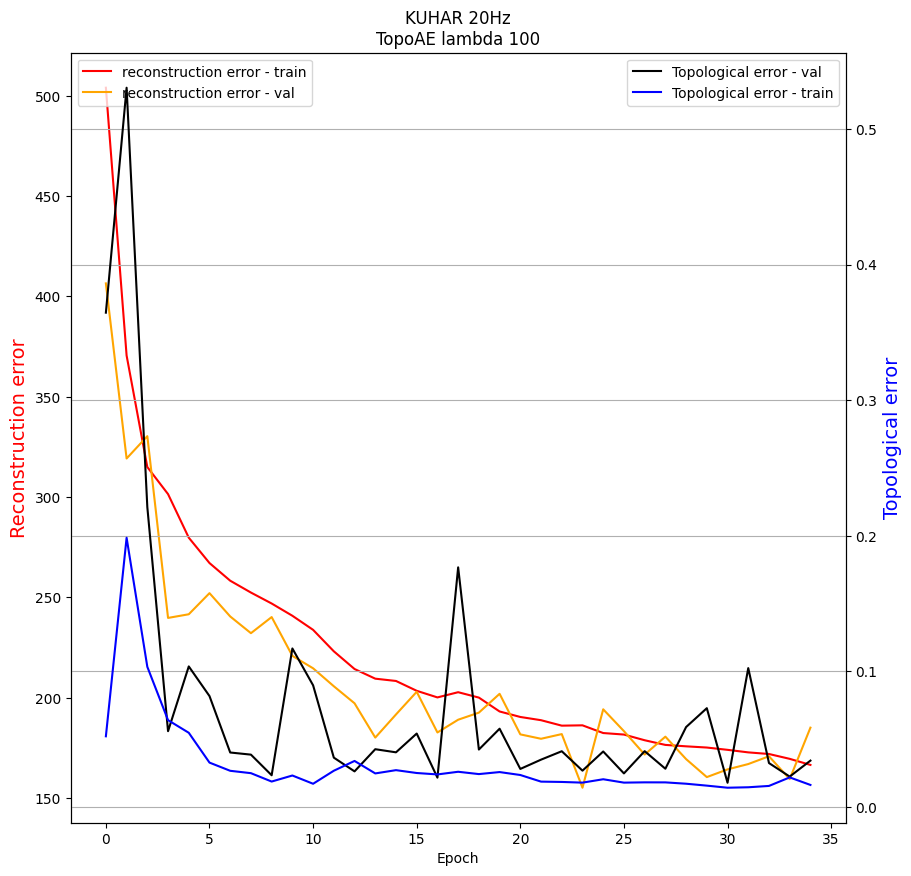

In [31]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [32]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [33]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.4515873015873016,
 'RF-F1': 0.4628049756698999,
 'SVC-ACC': 0.4021164021164021,
 'SVC-F1': 0.44255388230853765,
 'KNN-ACC': 0.3862433862433862,
 'KNN-F1': 0.39199275786771626}

In [34]:
table_info['Topo-AEv2 (L=100)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=100)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=100)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=100)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=100)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=100)'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │     0.428042 │          0.493122 │ 0.4515873015873016  │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │     0.437807 │          0.504451 │ 0.4628049756698999  │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │     0.338624 │          0.410053 │ 0.4021164021164021  │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────

## Obtain quality metrics

In [35]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [36]:
metrics_report

{'residual variance (pearson)': 0.19042969853583158,
 'residual variance (spearman)': 0.2887078214353833,
 'trustworthiness': 0.8608699126358406,
 'continuity': 0.9402677869460753,
 'co k nearest neighbor size': 0.3338859416445623,
 'local continuity meta criterion': 0.2913327501552006,
 'local property': 0.4530381523629275,
 'global property': 0.8583868880401933}

In [37]:
table_info['Topo-AEv2 (L=100)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=100)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=100)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ -      │     0.428042 │          0.493122 │            0.451587 │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ -      │     0.437807 │          0.504451 │            0.462805 │ -            │ -              │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ -      │     0.338624 │          0.410053 │            0.402116 │ -            │ -              │
├─────────────────┼────────┼──────────────┼─────────────

## Visualization

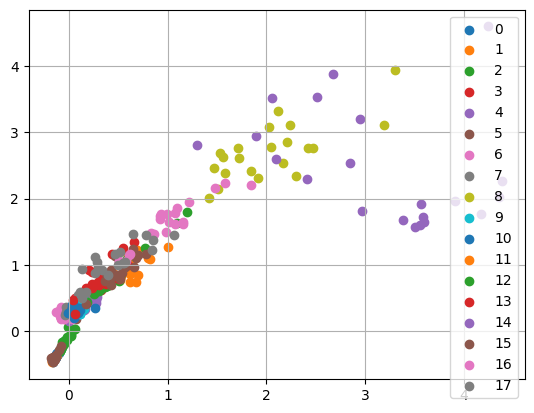

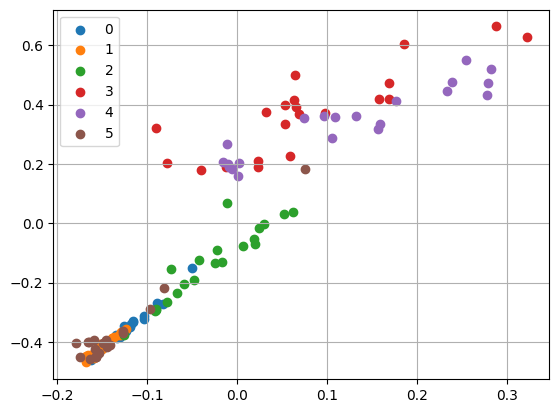

In [38]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [39]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [40]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [41]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.788888888888889,
 'RF-F1': 0.7939077018542571,
 'SVC-ACC': 0.8068783068783069,
 'SVC-F1': 0.8128458715988768,
 'KNN-ACC': 0.8042328042328042,
 'KNN-F1': 0.8097016720895794}

In [42]:
table_info['UMAP'][0] = experiments_result['RF-ACC']
table_info['UMAP'][1] = experiments_result['RF-F1']
table_info['UMAP'][2] = experiments_result['SVC-ACC']
table_info['UMAP'][3] = experiments_result['SVC-F1']
table_info['UMAP'][4] = experiments_result['KNN-ACC']
table_info['UMAP'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ 0.788888888888889  │     0.428042 │          0.493122 │            0.451587 │ -            │ -              │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ 0.7939077018542571 │     0.437807 │          0.504451 │            0.462805 │ -            │ -              │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ 0.8068783068783069 │     0.338624 │          0.410053 │            0.4

## Obtain quality metrics

In [43]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [44]:
metrics_report

{'residual variance (pearson)': 0.9164042083341901,
 'residual variance (spearman)': 0.9112567053609318,
 'trustworthiness': 0.8916131509144213,
 'continuity': 0.8811344114859254,
 'co k nearest neighbor size': 0.4870689655172414,
 'local continuity meta criterion': 0.4445157740278797,
 'local property': 0.40299113721527513,
 'global property': 0.6680511428088451}

In [45]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │ M-AE (L=1)   │ M-AE (L=100)   │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ 0.788889 │     0.428042 │          0.493122 │            0.451587 │ -            │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ 0.793908 │     0.437807 │          0.504451 │            0.462805 │ -            │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ 0.806878 │     0.338624 │          0.410053 │            0.402116 │ -            │ -              │
├─────────────────┼──────────┼──────────

## Visualization

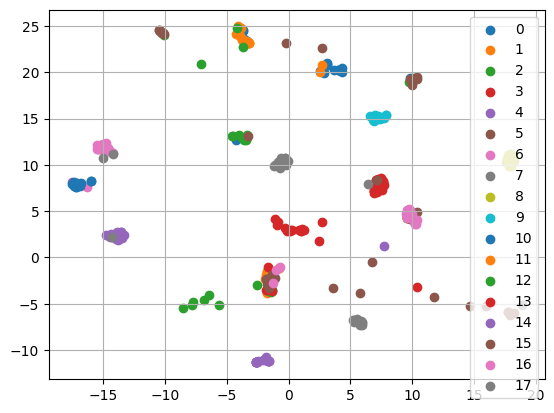

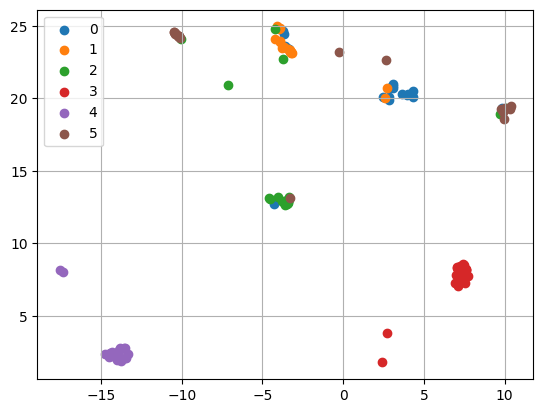

In [46]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=1)

In [47]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 1
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

coknns regularized DeepAEforKuhar180ver2
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:338.2900, Loss-ae:337.8502, Loss-metric:0.5602
Epoch:2, P:10, Loss:292.6425, Loss-ae:292.2287, Loss-metric:0.5862
Epoch:3, P:10, Loss:264.1062, Loss-ae:263.6985, Loss-metric:0.5922
Epoch:4, P:10, Loss:257.2831, Loss-ae:256.8768, Loss-metric:0.5937
Epoch:5, P:10, Loss:206.9848, Loss-ae:206.5905, Loss-metric:0.6058
Epoch:6, P:10, Loss:205.9778, Loss-ae:205.6069, Loss-metric:0.6291
Epoch:7, P:10, Loss:214.3651, Loss-ae:213.9914, Loss-metric:0.6263
Epoch:8, P:9, Loss:160.8508, Loss-ae:160.4849, Loss-metric:0.6341
Epoch:9, P:10, Loss:176.3494, Loss-ae:175.9780, Loss-metric:0.6286
Epoch:10, P:9, Loss:146.3860, Loss-ae:146.0128, Loss-metric:0.6268
Epoch:11, P:10, Loss:154.4311, Loss-ae:154.0479, Loss-metric:0.6168
Epoch:12, P:9, Loss:151.8466, Loss-ae:151.4740, Loss-metric:0.6274
Epoch:13, P:8, Loss:144.9933, Loss-ae:144.6148, Loss-metric:0.6215
Epoch:14, P:10, Loss:143.3370, Loss-ae:142.9479, Loss-metric:0.6109
Epoch:15, P:10, Loss:145.5104, Loss-ae:145.1433, Loss-metric:

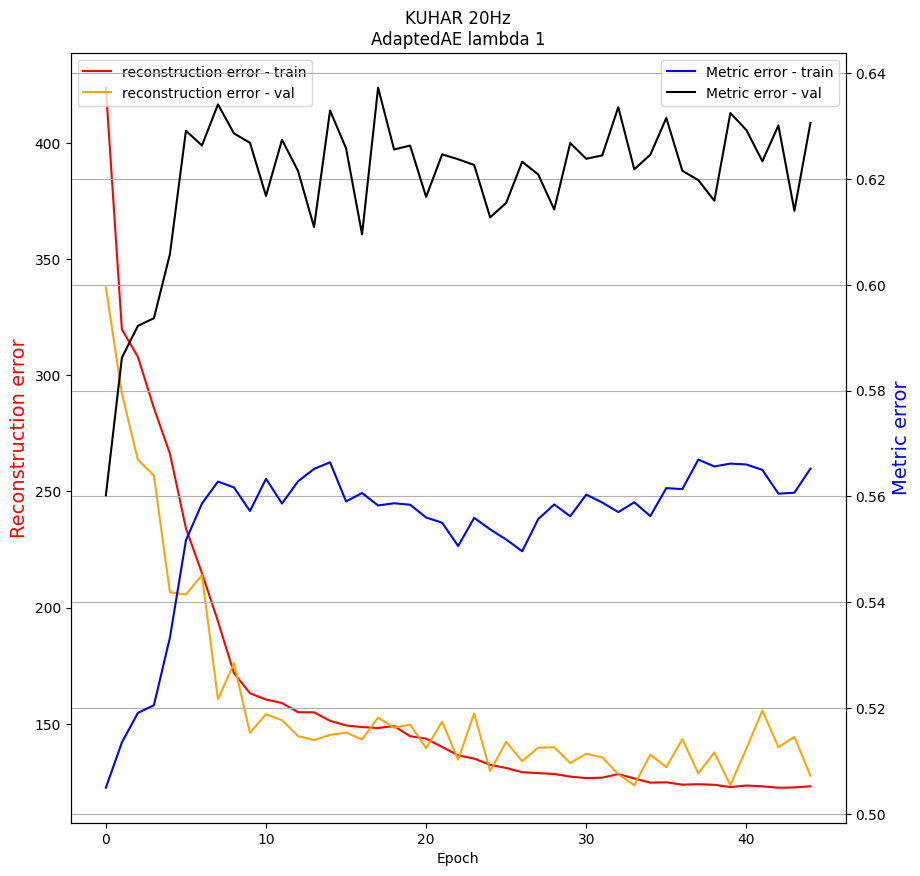

In [48]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [49]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [50]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.39656084656084656,
 'RF-F1': 0.40988361867531403,
 'SVC-ACC': 0.32275132275132273,
 'SVC-F1': 0.3705735278228777,
 'KNN-ACC': 0.40476190476190477,
 'KNN-F1': 0.412173919687861}

In [51]:
table_info['M-AE (L=1)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=1)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=1)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=1)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=1)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=1)'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╤═════════════════════╤════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │ M-AE (L=1)          │ M-AE (L=100)   │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╪═════════════════════╪════════════════╡
│ RF-ACC          │ 0.788889 │     0.428042 │          0.493122 │            0.451587 │ 0.39656084656084656 │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼─────────────────────┼────────────────┤
│ RF-F1           │ 0.793908 │     0.437807 │          0.504451 │            0.462805 │ 0.40988361867531403 │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼─────────────────────┼────────────────┤
│ SVC-ACC         │ 0.806878 │     0.338624 │          0.410053 │            0.402116 │ 0.32275132275132273 │ -

## Obtain quality metrics

In [52]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [53]:
metrics_report

{'residual variance (pearson)': 0.1346803928107907,
 'residual variance (spearman)': 0.16538129071714602,
 'trustworthiness': 0.8721982299389406,
 'continuity': 0.944049097334989,
 'co k nearest neighbor size': 0.3875994694960212,
 'local continuity meta criterion': 0.3450462780066595,
 'local property': 0.49805229341982543,
 'global property': 0.8866323862474806}

In [54]:
table_info['M-AE (L=1)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=1)'][7] = metrics_report['continuity']
table_info['M-AE (L=1)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │   M-AE (L=1) │ M-AE (L=100)   │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ 0.788889 │     0.428042 │          0.493122 │            0.451587 │     0.396561 │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ 0.793908 │     0.437807 │          0.504451 │            0.462805 │     0.409884 │ -              │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ 0.806878 │     0.338624 │          0.410053 │            0.402116 │     0.322751 │ -              │
├─────────────────┼──────────┼──────────

## Visualization

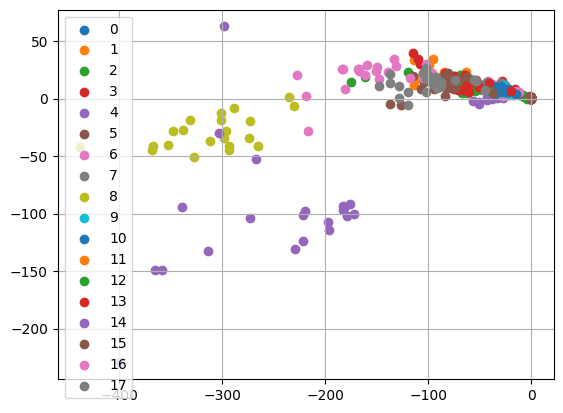

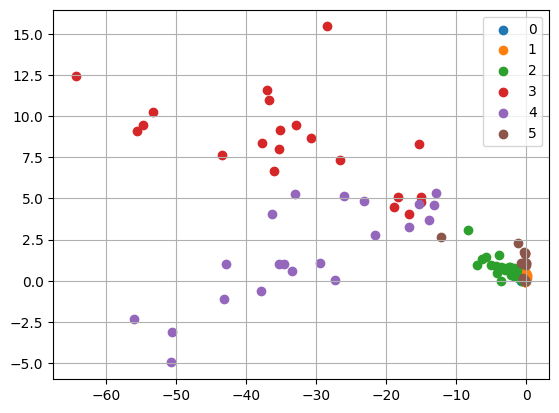

In [55]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=100)

In [56]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 100
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

coknns regularized DeepAEforKuhar180ver2
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:335.4632, Loss-ae:291.4685, Loss-metric:0.5601
Epoch:2, P:10, Loss:292.5201, Loss-ae:250.3564, Loss-metric:0.5784
Epoch:3, P:10, Loss:321.0117, Loss-ae:279.2834, Loss-metric:0.5827
Epoch:4, P:9, Loss:275.7589, Loss-ae:234.6178, Loss-metric:0.5886
Epoch:5, P:10, Loss:285.7432, Loss-ae:244.6701, Loss-metric:0.5893
Epoch:6, P:9, Loss:239.8571, Loss-ae:203.0313, Loss-metric:0.6317
Epoch:7, P:10, Loss:234.4724, Loss-ae:197.4832, Loss-metric:0.6301
Epoch:8, P:10, Loss:206.6410, Loss-ae:169.5062, Loss-metric:0.6287
Epoch:9, P:10, Loss:193.6012, Loss-ae:155.6218, Loss-metric:0.6202
Epoch:10, P:10, Loss:194.4592, Loss-ae:156.8306, Loss-metric:0.6237
Epoch:11, P:9, Loss:187.3547, Loss-ae:148.3360, Loss-metric:0.6098
Epoch:12, P:10, Loss:187.1208, Loss-ae:149.1100, Loss-metric:0.6199
Epoch:13, P:10, Loss:181.5111, Loss-ae:142.7188, Loss-metric:0.6121
Epoch:14, P:10, Loss:204.6465, Loss-ae:166.2614, Loss-metric:0.6161
Epoch:15, P:9, Loss:180.5582, Loss-ae:141.7117, Loss-metric:

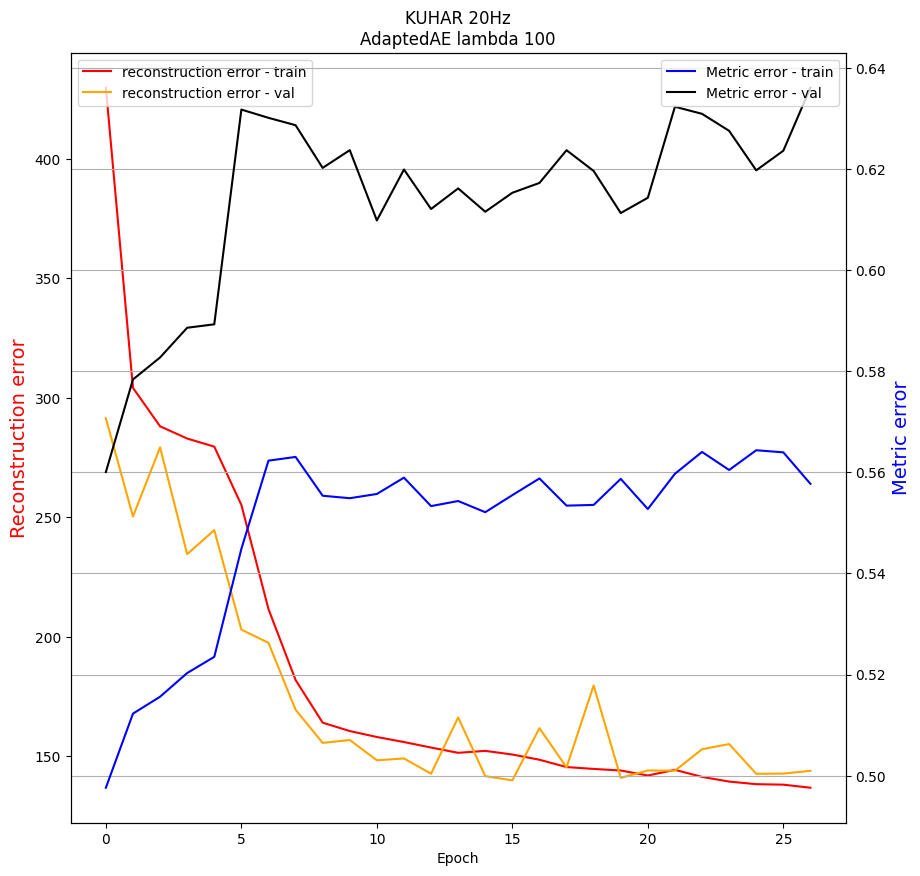

In [57]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [58]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


## Obtain classification metrics (RF, SVC, KNN)

In [59]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.42433862433862435,
 'RF-F1': 0.4286727792929506,
 'SVC-ACC': 0.3148148148148148,
 'SVC-F1': 0.36438442847195107,
 'KNN-ACC': 0.40476190476190477,
 'KNN-F1': 0.4049800801830798}

In [60]:
table_info['M-AE (L=100)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=100)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=100)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=100)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=100)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=100)'][5] = experiments_result['KNN-F1']

print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤═════════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │   M-AE (L=1) │ M-AE (L=100)        │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪═════════════════════╡
│ RF-ACC          │ 0.788889 │     0.428042 │          0.493122 │            0.451587 │     0.396561 │ 0.42433862433862435 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼─────────────────────┤
│ RF-F1           │ 0.793908 │     0.437807 │          0.504451 │            0.462805 │     0.409884 │ 0.4286727792929506  │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼─────────────────────┤
│ SVC-ACC         │ 0.806878 │     0.338624 │          0.410053 │            0.402116 │     0.322751 │ 0.3148148148148148  │


## Obtain quality metrics

In [61]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [62]:
metrics_report

{'residual variance (pearson)': 0.1299020354824768,
 'residual variance (spearman)': 0.16904965866710264,
 'trustworthiness': 0.8590430905897999,
 'continuity': 0.9452770817872547,
 'co k nearest neighbor size': 0.3778183023872679,
 'local continuity meta criterion': 0.33526511089790617,
 'local property': 0.4991773726211043,
 'global property': 0.8861060584049832}

In [63]:
table_info['M-AE (L=100)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=100)'][7] = metrics_report['continuity']
table_info['M-AE (L=100)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╤══════════════╤════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │   M-AE (L=1) │   M-AE (L=100) │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╪══════════════╪════════════════╡
│ RF-ACC          │ 0.788889 │     0.428042 │          0.493122 │            0.451587 │     0.396561 │       0.424339 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ RF-F1           │ 0.793908 │     0.437807 │          0.504451 │            0.462805 │     0.409884 │       0.428673 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┼──────────────┼────────────────┤
│ SVC-ACC         │ 0.806878 │     0.338624 │          0.410053 │            0.402116 │     0.322751 │       0.314815 │
├─────────────────┼──────────┼──────────

## Visualization

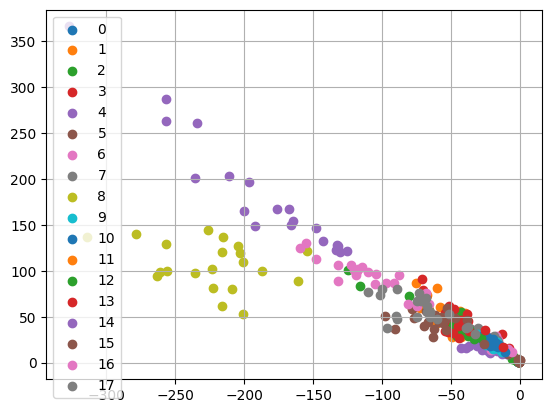

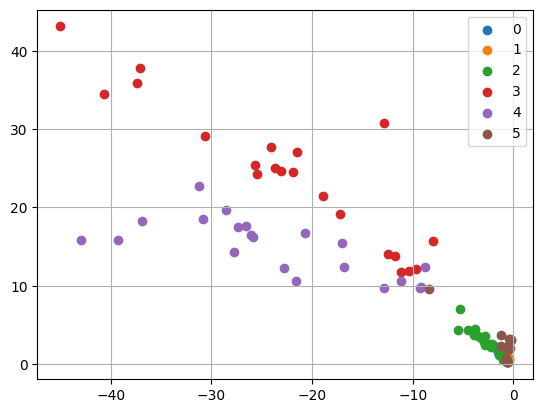

In [64]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run